# Neo4j (grafos), sesión 7, 2025-26

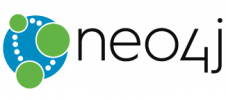

Esta hoja muestra cómo acceder a bases de datos Neo4j y también a conectar la salida con Google Colab/Jupyter:

In [1]:
RunningInCOLAB: bool = (
    "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
)

In [2]:
if RunningInCOLAB:
    import urllib.request

    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/dsevilla/bdge/refs/heads/25-26/addendum/frp-neo4j/setup-neo4j-colab.sh",
        "setup-neo4j-colab.sh",
    )

In [3]:
%%capture URL_output
if RunningInCOLAB:
    !sh ./setup-neo4j-colab.sh

In [4]:
if RunningInCOLAB:
    print(URL_output)

70 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
apt-utils is already the newest version (2.4.14).
ca-certificates is already the newest version (20240203~22.04.1).
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  openjdk-11-jre-headless
Suggested packages:
  default-jre libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  apt-transport-https default-jre-headless openjdk-11-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 70 not upgraded.
Need to get 42.6 MB of archives.
After this operation, 176 MB of additional disk space will be used.
debconf: unable to initialize frontend:

In [4]:
import os

BOLT_URL: str = f"bolt://{os.getenv('DB_HOSTNAME', 'localhost')}:7687"
if RunningInCOLAB:
    BOLT_URL = URL_output.stdout.split(os.linesep)[-2]
    HTTP_URL: str = URL_output.stdout.split(os.linesep)[-3]
    print(f"URL de conexión de BOLT:\n{BOLT_URL}")
    print(f"URL de conexión al interfaz Web:\n{HTTP_URL}")

URL de conexión de BOLT:
bolt://dsevilla-proxy.inf.um.es:8145
URL de conexión al interfaz Web:
http://dsevilla-proxy.inf.um.es:8144


In [5]:
%pip install --upgrade neo4j-driver duckdb 'pandas[performance,parquet]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [6]:
from pprint import pprint as pp

import pandas as pd

<details><summary><b>🗂️ Formato datos Stack Overflow (completo)</b> <span style="color: #007acc;">▶️ Haz click para ver el esquema y ejemplos</span></summary>

> Notas generales
- Formato: cada fichero es XML y suele distribuirse 7zipped.
- Codificación: UTF-8. Los campos de fecha siguen el formato ISO8601: "YYYY-MM-DDTHH:mm:ss.fff".
- Nulos: cuando un campo no aplica (p.ej., `ParentId` en preguntas), no aparece o viene vacío; en nuestros Parquet suele ser `null`.
- Identificadores: `Id` es clave primaria en cada entidad. Claves foráneas enlazan por `Id` entre ficheros.

---

:file_folder: <b>badges.xml</b> (insignias logradas por usuarios)
- UserId: Id del usuario que recibe la insignia. Ej: 420. Uso: FK a `users.Id`.
- Name: Nombre de la insignia. Ej: "Teacher". Uso: clasificar tipo de logro.
- Date: Fecha de concesión. Ej: "2008-09-15T08:55:03.923". Uso: series temporales.
- Class: Categoría (1=Gold, 2=Silver, 3=Bronze). Ej: 3. Uso: nivel de la insignia.
- TagBased: Si la insignia es específica de etiqueta. Ej: true. Uso: filtrar logros por etiquetas.

---

:file_folder: <b>comments.xml</b> (comentarios en publicaciones)
- Id: Identificador del comentario. Ej: 12345. Uso: PK.
- PostId: Publicación a la que comenta. Ej: 100234. Uso: FK a `posts.Id`.
- Score: Puntuación del comentario. Ej: 5. Uso: ordenar/filtrar relevancia.
- Text: Texto del comentario. Ej: "¿Puedes compartir el error exacto?". Uso: contenido.
- CreationDate: Fecha de creación. Ej: "2008-09-06T08:07:10.730". Uso: análisis temporal.
- UserId: Autor del comentario. Ej: 314159. Uso: FK a `users.Id`.
- UserDisplayName: Nombre mostrado si el usuario fue eliminado. Ej: "user123". Uso: se usa cuando `UserId` es nulo/ausente.
- ContentLicense: Licencia del contenido. Ej: "CC BY-SA 4.0". Uso: cumplimiento/licencias.

---

:file_folder: <b>posts.xml</b> (preguntas y respuestas)
- Id: Identificador de la publicación. Ej: 98765. Uso: PK.
- PostTypeId: Tipo (1=Pregunta, 2=Respuesta). Ej: 1. Uso: rutas de procesamiento/particionado.
- ParentId: Id de la pregunta padre si es respuesta. Ej: 1234. Uso: FK a `posts.Id` (solo si `PostTypeId=2`).
- AcceptedAnswerId: Id de la respuesta aceptada (solo en preguntas). Ej: 4567. Uso: FK a `posts.Id` para marcar aceptadas.
- CreationDate: Fecha de creación. Ej: "2010-02-15T10:21:34.120". Uso: análisis temporal.
- Score: Votos netos (upvotes-downvotes). Ej: 42. Uso: ranking/calidad.
- ViewCount: Nº de vistas (solo preguntas). Ej: 12345. Uso: popularidad.
- Body: HTML/Markdown del cuerpo. Ej: "<p>¿Cómo...?</p>". Uso: contenido/NLP.
- OwnerUserId: Autor. Ej: 271828. Uso: FK a `users.Id`.
- OwnerDisplayName: Nombre mostrado si el autor fue eliminado. Ej: "John Doe". Uso: se usa cuando `OwnerUserId` es nulo (usuario eliminado o anónimo).
- LastEditorUserId: Último usuario que editó. Ej: 314159. Uso: FK a `users.Id`.
- LastEditorDisplayName: Nombre si el editor fue eliminado. Ej: "Community". Uso: solo cuando `LastEditorUserId` es nulo.
- LastEditDate: Fecha de última edición. Ej: "2009-03-05T22:28:34.823". Uso: auditoría.
- LastActivityDate: Última actividad (edición, comentario, etc.). Ej: "2009-03-11T12:51:01.480". Uso: ordenación por actividad reciente.
- CommunityOwnedDate: Fecha desde la que es de la comunidad. Ej: "2009-03-11T12:51:01.480". Uso: gobernanza.
- ClosedDate: Fecha de cierre (si procede). Ej: "2012-01-01T12:00:00.000". Uso: moderación.
- Title: Título de la pregunta. Ej: "¿Cómo unir listas en Python?". Uso: metadata/búsqueda.
- Tags: Lista de etiquetas en formato XML/HTML: "<python><list><merge>". Uso: clasificación por tema.
- AnswerCount: Nº de respuestas (en preguntas). Ej: 5. Uso: engagement.
- CommentCount: Nº de comentarios. Ej: 3. Uso: actividad.
- FavoriteCount: Favoritos marcados (legacy). Ej: 10. Uso: popularidad histórica.
- ContentLicense: Licencia. Ej: "CC BY-SA 4.0". Uso: cumplimiento.

---

:file_folder: <b>posthistory.xml</b> (historial detallado de cambios)
- Id: PK del evento de historial. Ej: 5555.
- PostHistoryTypeId: Tipo de cambio. Uso: clasifica el evento. Ejemplos:
  - 1: Initial Title – primer título de la pregunta.
  - 2: Initial Body – primer cuerpo en crudo.
  - 3: Initial Tags – primeras etiquetas.
  - 4: Edit Title – cambio de título.
  - 5: Edit Body – cambio de cuerpo (markdown crudo).
  - 6: Edit Tags – cambio de etiquetas.
  - 7/8/9: Rollback Title/Body/Tags – revertidos.
  - 10: Post Closed – cierre por votos.
  - 11: Post Reopened – reapertura.
  - 12/13: Post Deleted/Undeleted – borrado/restaurado.
  - 14/15: Post Locked/Unlocked – bloqueado/desbloqueado.
  - 16: Community Owned – pasa a comunidad.
  - 17: Post Migrated – migración (origen/destino).
  - 18: Question Merged – fusión de preguntas.
  - 19/20: Question Protected/Unprotected – protegido/desprotegido.
  - 21: Post Disassociated – se elimina el OwnerUserId.
  - 22: Question Unmerged – deshace fusión.
- PostId: Publicación afectada. Ej: 98765. Uso: FK a `posts.Id`.
- RevisionGUID: Agrupa múltiples registros de un mismo acto. Ej: "3E5B...". Uso: correlación.
- CreationDate: Fecha del evento. Ej: "2009-03-05T22:28:34.823".
- UserId: Usuario que realiza el cambio. Ej: 271828. Uso: FK a `users.Id`.
- UserDisplayName: Si el usuario fue eliminado. Ej: "user123". Uso: cuando `UserId` nulo.
- Comment: Comentario del editor. Ej: "typo fix". Uso: auditoría.
- Text: Valor crudo nuevo asociado al cambio. Ej: nuevo markdown o JSON.
  - Para tipos 10–15: JSON con usuarios que han votado esa acción de moderación.
  - Para tipo 17: Detalles de migración: "from <url>" o "to <url>".
- CloseReasonId: Motivo de cierre (histórico). Ejemplos:
  - 1: Exact Duplicate – duplicada de otra.
  - 2: off-topic – fuera de tema.
  - 3: subjective – demasiado subjetiva.
  - 4: not a real question – no es una pregunta real.
  - 7: too localized – demasiado localizada.

---

:file_folder: <b>postlinks.xml</b> (enlaces entre publicaciones)
- Id: PK del enlace. Ej: 2222.
- CreationDate: Fecha del enlace. Ej: "2011-05-05T10:00:00.000".
- PostId: Publicación origen. Ej: 1000. Uso: FK a `posts.Id`.
- RelatedPostId: Publicación destino. Ej: 1001. Uso: FK a `posts.Id`.
- PostLinkTypeId: Tipo de relación. Uso: grafo entre posts.
  - 1: Linked – relacionados.
  - 3: Duplicate – duplicados.

---

:file_folder: <b>users.xml</b> (usuarios)
- Id: PK del usuario. Ej: 271828.
- AccountId: Id de cuenta en la red Stack Exchange. Ej: 123456. Uso: consolidación multi-sitio.
- Reputation: Reputación. Ej: 15234. Uso: privilegios/ordenación.
- CreationDate: Alta del usuario. Ej: "2008-07-31T21:42:52.667".
- DisplayName: Nombre mostrado. Ej: "Jane Doe". Uso: UI.
- EmailHash: Hash MD5 de email (legacy). Ej: "fcea920f...". Uso: avatar histórico.
- LastAccessDate: Último acceso. Ej: "2020-04-01T12:00:00.000". Uso: actividad.
- WebsiteUrl: Web personal. Ej: "https://janedoe.dev".
- Location: Ubicación libre. Ej: "Madrid, ES".
- Age: Edad (cuando se compartía). Ej: 32.
- AboutMe: BIO en HTML/Markdown. Ej: "<p>Desarrollo datos...</p>".
- Views: Visitas al perfil. Ej: 1234.
- UpVotes: Upvotes emitidos por el usuario. Ej: 500.
- DownVotes: Downvotes emitidos. Ej: 20.
- ProfileImageUrl: Avatar. Ej: "https://.../image.png".

---

:file_folder: <b>votes.xml</b> (votos a publicaciones)
- Id: PK del voto. Ej: 7777.
- PostId: Publicación votada. Ej: 98765. Uso: FK a `posts.Id`.
- VoteTypeId: Tipo de voto/acción. Uso: métricas de calidad/moderación.
  - 1: AcceptedByOriginator – el autor de la pregunta acepta una respuesta (equivale a `AcceptedAnswerId`).
  - 2: UpMod – upvote.
  - 3: DownMod – downvote.
  - 4: Offensive – ofensivo (legacy).
  - 5: Favorite – marcado como favorito (legacy); si `VoteTypeId=5`, `UserId` se rellena.
  - 6: Close – voto de cierre.
  - 7: Reopen – voto de reapertura.
  - 8: BountyStart – inicio de recompensa.
  - 9: BountyClose – cierre de recompensa; si `VoteTypeId=9`, `BountyAmount` se rellena.
  - 10: Deletion – voto de borrado.
  - 11: Undeletion – voto de restauración.
  - 12: Spam – marcado como spam.
  - 13: InformModerator – informar a moderación.
- CreationDate: Fecha del voto. Ej: "2015-06-10T09:30:00.000".
- UserId: Usuario que vota (solo para algunos tipos como 5). Ej: 54321. Uso: FK a `users.Id`.
- BountyAmount: Cantidad de recompensa (solo tipo 9). Ej: 100.

---

:file_folder: <b>tags.xml</b> (etiquetas del sitio)
- Id: PK de la etiqueta. Ej: 42.
- TagName: Nombre de la etiqueta. Ej: "python". Uso: clasificación temática.
- Count: Nº de usos en preguntas. Ej: 150234. Uso: popularidad.
- ExcerptPostId: Id del post con el extracto de la wiki de etiqueta. Ej: 123. Uso: FK a `posts.Id`.
- WikiPostId: Id del post con el artículo de la wiki de etiqueta. Ej: 124. Uso: FK a `posts.Id`.

</details>

Conexión asíncrona a la base de datos:

In [7]:
from neo4j import AsyncDriver, AsyncGraphDatabase, EagerResult, basic_auth

cypher_query = """
MATCH (n)
RETURN n AS id
LIMIT 10;
"""

a_driver: AsyncDriver = AsyncGraphDatabase.driver(BOLT_URL, auth=basic_auth("neo4j", ""))

result: EagerResult = await a_driver.execute_query(cypher_query)
for record in result.records:
    print(record["id"])

### Creación de Constraints (Restricciones de Integridad)

Antes de cargar los datos, es una **buena práctica** crear constraints de unicidad en los atributos que identifican de manera única a cada nodo. Los constraints no solo aseguran la integridad de los datos (evitando duplicados), sino que también crean automáticamente **índices** que aceleran enormemente las operaciones `MERGE` y las búsquedas.

En nuestro modelo de datos de StackOverflow:
- Cada `User` se identifica de forma única por su `Id`
- Cada `Post` (que puede ser `Question` o `Answer`) se identifica de forma única por su `Id`

Crear estos constraints **antes** de la carga masiva de datos mejorará significativamente el rendimiento.

In [8]:
# Crear constraint de unicidad para User.Id
# Esto crea automáticamente un índice en User.Id
await a_driver.execute_query(
    """
    CREATE CONSTRAINT user_id_unique IF NOT EXISTS
    FOR (u:User) REQUIRE u.Id IS UNIQUE
    """
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f71aea9a00>, keys=[])

In [9]:
# Crear constraint de unicidad para Post.Id
# Esto beneficia tanto a Questions como a Answers (que heredan de Post)
await a_driver.execute_query(
    """
    CREATE CONSTRAINT post_id_unique IF NOT EXISTS
    FOR (p:Post) REQUIRE p.Id IS UNIQUE
    """
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f707bec140>, keys=[])

In [10]:
# Crear constraint de unicidad para Comment.Id
# Esto beneficia tanto a Questions como a Answers (que heredan de Post)
await a_driver.execute_query(
    """
    CREATE CONSTRAINT comment_id_unique IF NOT EXISTS
    FOR (c:Comment) REQUIRE c.Id IS UNIQUE
    """
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f70b630bf0>, keys=[])

**Nota importante:** Con estos constraints creados, Neo4j garantiza que:
1. No se pueden insertar dos nodos `User` con el mismo `Id`
2. No se pueden insertar dos nodos `Post` con el mismo `Id`
3. No se pueden insertar dos nodos `Comment` con el mismo `Id`
4. Las operaciones `MERGE` serán mucho más rápidas gracias a los índices creados automáticamente

Ahora podemos proceder con la carga de datos con la confianza de que no habrá duplicados y con un rendimiento óptimo.

In [11]:
import duckdb
from duckdb import DuckDBPyRelation

BASE_URL: str = "https://github.com/dsevilla/bd2-data/releases/download/parquet-files-25-26"

# Algunas optimizaciones para duckdb.
duckdb.sql("PRAGMA enable_object_cache;")

ddb_posts: DuckDBPyRelation = duckdb.read_parquet(f"{BASE_URL}/Posts.parquet")

In [12]:
import os
from asyncio import Semaphore, Task, create_task, gather
from collections.abc import Iterator
from typing import cast

from pandas import DataFrame
from typing_extensions import LiteralString

from neo4j import EagerResult


async def load_dataframe_neo4j(
    tag: str, df: DuckDBPyRelation, a_driver: AsyncDriver
) -> list[EagerResult]:
    sem: Semaphore = Semaphore(int((os.cpu_count() or 2) * 1.5))

    async def execute_add_query(
        rows: DataFrame, sem: Semaphore, a_driver: AsyncDriver
    ) -> EagerResult:
        async with sem:
            return await a_driver.execute_query(
                cast(
                    LiteralString,
                    f"""
                UNWIND $batch AS node
                CREATE (p:{tag})
                SET p = node;""",
                ),
                batch=rows.to_dict(orient="records"),
            )

    def generate_chunks(
        df: DuckDBPyRelation, sem: Semaphore, a_driver: AsyncDriver
    ) -> Iterator[Task[EagerResult]]:
        while True:
            chunk: DataFrame = df.fetch_df_chunk(5)  # 5*2048
            if chunk.empty:
                break
            yield create_task(execute_add_query(chunk, sem, a_driver))

    # Generate all chunks and execute them concurrently. Wait for all to complete.
    all_chunks: Iterator[Task[EagerResult]] = generate_chunks(df, sem, a_driver)
    return await gather(*all_chunks)

Cargar los posts en segundo plano.

In [13]:
load_posts_task: Task[list[EagerResult]] = create_task(
    load_dataframe_neo4j("Post", ddb_posts, a_driver)
);

### OJO, ELIMINANDO COSAS:
Para borrar la base de datos entera, por si se cometen errores:

    CALL () {
      MATCH (n)
      DETACH DELETE n
    } IN TRANSACTIONS OF 10000 ROWS

In [14]:
# Usa esto en una celda separada (no dentro de execute_write)
async def clear_database() -> None:
    query = """
    CALL () {
      MATCH (n)
      DETACH DELETE n
    } IN TRANSACTIONS OF 10000 ROWS
    """
    # Forzar sesión auto-commit
    async with a_driver.session() as session:
        await session.run(query)

A todas las preguntas, se las etiqueta con `Question`. Antes, se debe asegurar de que la importación ha terminado.

In [15]:
await load_posts_task

[EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f555a6f0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f424cf20>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f6313aa0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f45cef30>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f6706cf0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6fc128e90>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f638c890>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f73c571f70>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f4e157c0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.R

También eliminaremos toda la memoria de la caché de DuckDB. Esto deja más espacio para trabajar con el Notebook, ya que gran parte de la base de datos de Neo4j y los datos recuperados en remoto se almacenan en la memoria.

In [16]:
duckdb.close()  # Cierra la conexión implícita.

In [17]:
result: EagerResult = await a_driver.execute_query(
    """
    MATCH (n:Post {PostTypeId : 1})
      SET n:Question;
    """
)
pp(result.summary.counters)

{'_contains_updates': True, 'labels_added': 194788}


A todas las respuestas se las etiqueta con `Answer`.

In [18]:
result: EagerResult = await a_driver.execute_query(
    """
      MATCH (n:Post {PostTypeId : 2})
        SET n:Answer;
    """
)
pp(result.summary.counters)

{'_contains_updates': True, 'labels_added': 211615}


### Creando nodos y relaciones

Se crea un nodo usuario (o se utiliza uno si ya existe) usando el campo `OwnerUserId`, siempre que no esté vacío. Nótese que se puede utilizar `CREATE` porque esta combinación de relación usuario y pregunta no existe. Cuidado, si se ejecuta dos veces creará el doble de relaciones. Se aprovecha para añadir una característica a la propia relación, la fecha de creación de la pregunta por parte del usuario.

In [19]:
result: EagerResult = await a_driver.execute_query(
    """
    MATCH (n:Post)
    WHERE n.OwnerUserId <> ""
        MERGE (u:User {Id: n.OwnerUserId})
        CREATE (u)-[:WROTE {CreationDate: n.CreationDate}]->(n);
    """
)
pp(result.summary.counters)

{'_contains_updates': True, 'labels_added': 78684, 'relationships_created': 403879, 'nodes_created': 78684, 'properties_set': 482563}


Añadimos una relación entre las preguntas y las respuestas:

In [20]:
result: EagerResult = await a_driver.execute_query(
    """
    MATCH (a:Answer), (q:Question {Id: a.ParentId})
    CREATE (a)-[:ANSWERS]->(q)
    """
)
pp(result.summary.counters)

{'_contains_updates': True, 'relationships_created': 211615}


In [21]:
query = """
// RQ4 creando relaciones de reciprocidad
MATCH
  (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
  (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1.Id < u2.Id
WITH u1 AS user1, u2 AS user2
  MERGE (user1)-[:RECIPROCATE]->(user2)
  MERGE (user2)-[:RECIPROCATE]->(user1)
"""

result: EagerResult = await a_driver.execute_query(query)
for r in result.records:
    pp(r)

**Ejemplo**: Clúster de usuarios conectados con intereses comunes. Usuarios que están conectados por un camino de al menos 3 saltos (pregunta-respuesta-pregunta-respuesta) y que comparten un conjunto de al menos 2 etiquetas en sus preguntas. Ordenarlos por el número de etiquetas compartidas y la longitud del camino.

In [22]:
query = """
MATCH path=(u1:User)-[:RECIPROCATE*1..3]-(u2:User)
WHERE id(u1) < id(u2)
WITH u1, u2, path
MATCH (u1)-[:INTERESTED_IN]->(t:Tag)<-[:INTERESTED_IN]-(u2)
WITH u1, u2, collect(DISTINCT t.TagName) AS common_tags, length(path) AS distance
WHERE size(common_tags) >= 2
RETURN u1.Id AS user1, u2.Id AS user2, common_tags, distance
ORDER BY size(common_tags) DESC, distance ASC
LIMIT 20
"""

result: EagerResult = await a_driver.execute_query(query)
print("Pares de usuarios conectados con intereses comunes:")
for r in result.records:
    print(
        f"Usuario {r['user1']} <-> Usuario {r['user2']}: {len(r['common_tags'])} tags en común - Distancia: {r['distance']}"
    )
    print(f"  Tags: {', '.join(r['common_tags'][:5])}")  # Mostrar solo primeros 5 tags

Pares de usuarios conectados con intereses comunes:


## EJERCICIO: Construir los nodos `:Tag` para cada uno de los tags que aparecen en las preguntas. Construir las relaciones `post-[:TAGGED_WITH]->tag` para cada tag y también `tag-[:TAGS]->post`

(**OJO**: Hay que crear un índice antes para `Tag.TagName`, si no el proceso es muy lento)

Para ello, buscar en la ayuda las construcciones `WITH` y `UNWIND` y las funciones `replace()` y `split()` de Cypher.

In [23]:
# Crear constraint de unicidad para Tag.TagName
# Esto crea automáticamente un índice en Tag.TagName
await a_driver.execute_query(
    """
    CREATE CONSTRAINT tag_name_unique IF NOT EXISTS
    FOR (t:Tag) REQUIRE t.TagName IS UNIQUE
    """
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f707316c90>, keys=[])

Primero buscamos todas las preguntas (Question) que tienen algo en el campo Tags y  quitamos los símbolos < y >, donde haya una intersección >< ponemos una coma para separar los tags, todo esto usando REPLACE, dejando una cadena de tags separadas por comas.

Después convertimos esa cadena de texto en una lista de Cypher usando SPLIT y la desdoblamos con UNWIND para tratar cada tag por separado.
Por cada tag se crea un nodo Tag si no existe ya con ese nombre, y creamos las relaciones entre la pregunta y el tag en ambos sentidos (:TAGGED_WITH y :TAGS) si no existe esa relación ya.

In [24]:
query = """
MATCH (q:Question)
WHERE q.Tags IS NOT NULL AND q.Tags <> ''
WITH q,
     replace(
       replace(
         replace(q.Tags, '><', ','),
         '<', ''
       ),
       '>', ''
     ) AS tagStr
WITH q, [tag IN split(tagStr, ',') WHERE tag <> ''] AS tagList
UNWIND tagList AS tagName
MERGE (t:Tag {TagName: tagName})
MERGE (q)-[:TAGGED_WITH]->(t)
MERGE (t)-[:TAGS]->(q);
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f424d6d0>, keys=[])

La siguiente consulta debe retornar 26135 resultados:

In [25]:
query = """
MATCH p=(t:Tag)-[:TAGS]->(:Question) WHERE t.TagName =~ "^java$|^c\\\\+\\\\+$" RETURN count(p);
"""
result: EagerResult = await a_driver.execute_query(query)
for r in result.records:
    pp(r)

<Record count(p)=26135>


La siguiente consulta muestra los usuarios que preguntan por cada Tag:

In [26]:
query = "MATCH (t:Tag)-->(:Question)<--(u:User) RETURN t.TagName, collect(distinct u.Id) ORDER BY t.TagName;"

result: EagerResult = await a_driver.execute_query(query)
for r in result.records:
    pp(r)

<Record t.TagName='.asmx' collect(distinct u.Id)=[5997, 4361, 9039, 22880, 24842, 43605, 44806, 31417, 45749, 27002, 74103, 63368, 92992, 98900, 98937, 102304, 102912, 33311, 119957, 146914]>
<Record t.TagName='.bat' collect(distinct u.Id)=[342, 19277, 33934, 62857, 54459, 70288, 83304, 84738, 83726, 129678, 114296, 158389, 165828, 178040, 176564, 192004, 192192, 204079, 150131, 222047, 222131, 207956, 225728, 228129, 236528, 236725, 246559, 263674, 272326, 278010, 279698, 54170, 316973, 328305, 335011, 339672, 341292, 343104]>
<Record t.TagName='.env' collect(distinct u.Id)=[78241, 179365, 291724]>
<Record t.TagName='.htaccess' collect(distinct u.Id)=[517, 250, 12870, 5997, 9529, 10796, 16107, 6046, 9142, 7358, 4528, 2676, 6044, 5248, 4612, 9885, 7490, 5438, 4328, 18587, 9254, 1746, 18124, 19253, 9380, 4718, 19419, 9470, 14622, 2770, 19728, 4676, 6897, 9754, 2957, 18771, 9974, 166, 3092, 20153, 5583, 3248, 20493, 10365, 20709, 10399, 14025, 18478, 15481, 10486, 21882, 3947, 11342, 113

El mismo `MATCH` se puede usar para encontrar qué conjunto de tags ha usado cada usuario cambiando lo que retornamos:

In [27]:
query = (
    "MATCH (t:Tag)-->(:Question)<--(u:User) RETURN u.Id, collect(distinct t.TagName) ORDER BY u.Id;"
)

result: EagerResult = await a_driver.execute_query(query)
for r in result.records:
    pp(r)

Streaming output truncated to the last 5000 lines.
<Record u.Id=314488 collect(distinct t.TagName)=['wpf', 'sql-server', 'c#', 'visual-studio', 'datagrid']>
<Record u.Id=314496 collect(distinct t.TagName)=['express', 'deployment', 'sequelize.js', 'postgresql']>
<Record u.Id=314503 collect(distinct t.TagName)=['selenium', 'firefox', 'selenium-ide']>
<Record u.Id=314509 collect(distinct t.TagName)=['poo', 'arraylist', 'objeto', 'c#']>
<Record u.Id=314512 collect(distinct t.TagName)=['django', 'python', 'sql', 'postgresql']>
<Record u.Id=314528 collect(distinct t.TagName)=['python', 'label', 'c#', 'unity', 'unity2d']>
<Record u.Id=314534 collect(distinct t.TagName)=['php', 'json', 'javascript']>
<Record u.Id=314547 collect(distinct t.TagName)=['mysql-workbench']>
<Record u.Id=314554 collect(distinct t.TagName)=['mysql', 'python']>
<Record u.Id=314559 collect(distinct t.TagName)=['php']>
<Record u.Id=314564 collect(distinct t.TagName)=['firebase', 'firestore', 'java']>
<Record u.Id=314569 

## EJERCICIO: Relacionar cada usuario con los tags de sus preguntas a través de la relación `:INTERESTED_IN` (similar a E1).

Esta es sencilla, simplemente es buscar los tags sobre los que haya preguntado alguna vez el usuario y unir el usuario con dichos tags

In [28]:
query = """
MATCH (u:User)-[:WROTE]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
WITH DISTINCT u, t
MERGE (u)-[:INTERESTED_IN]->(t);
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f216c5f0>, keys=[])

## EJERCICIO: Cargar el Parquet de Users y añadir las propiedades faltantes a los usuarios (hasta ahora cada nodo `:User` sólo tiene la propiedad `Id`. Hay que cargar el resto a partir del Parquet). **CUIDADO**: El código de ejemplo crea nodos, pero no hace `MERGE` con los que hay. Hay que modificarlo para que haga `MERGE` y no cree duplicados.

Descargamos el fichero parquet con los datos

In [29]:
# Algunas optimizaciones para duckdb.
duckdb.sql("PRAGMA enable_object_cache;")

ddb_users: DuckDBPyRelation = duckdb.read_parquet(f"{BASE_URL}/Users.parquet")

Para cargar los datos desde parquet a nuestra base de datos vamos a usar la función que ya nos viene dada ```load_dataframe_neo4j``` que hace exactamente eso. Sin embargo para que funcione tenemos que hacerle un pequeño cambio. La función original lo que hace es recorrer los datos e ir creando un nodo nuevo en cada iteración:
```
UNWIND $batch AS node
CREATE (p:{tag})
SET p = node;""",
```
Sin embargo lo que nosotros queremos no es crear un nodo nuevo, si no buscar el que ya exista y añadirle los campos que le faltan. Esto lo conseguimos primero con MERGE en vez de CREATE y luego con SET. MERGE, ya lo hemos usado en consultas anteriores, es equivalente a un MATCH y CREATE. Es decir si no existe lo que queremos crear lo crea, y si ya existe usa el que ya existe. Buscamos el usuario con MERGE, si no existe lo crea, y le añadimos los campos que le faltan con SET, que se encarga justamente de actualizar las propiedades de los nodos.


In [30]:
async def update_Users_neo4j(
    tag: str, df: DuckDBPyRelation, a_driver: AsyncDriver
) -> list[EagerResult]:
    sem: Semaphore = Semaphore(int((os.cpu_count() or 2) * 1.5))

    async def execute_add_query(
        rows: DataFrame, sem: Semaphore, a_driver: AsyncDriver
    ) -> EagerResult:
        async with sem:
            return await a_driver.execute_query(
                cast(
                    LiteralString,
                    f"""
                    UNWIND $batch AS node
                    MERGE (p:{tag} {{Id: node.Id}})
                    SET p += node;""",
                ),
                batch=rows.to_dict(orient="records"),
            )

    def generate_chunks(
        df: DuckDBPyRelation, sem: Semaphore, a_driver: AsyncDriver
    ) -> Iterator[Task[EagerResult]]:
        while True:
            chunk: DataFrame = df.fetch_df_chunk(5)  # 5*2048
            if chunk.empty:
                break
            yield create_task(execute_add_query(chunk, sem, a_driver))

    # Generate all chunks and execute them concurrently. Wait for all to complete.
    all_chunks: Iterator[Task[EagerResult]] = generate_chunks(df, sem, a_driver)
    return await gather(*all_chunks)

In [31]:
update_Users_neo4j_task: Task[list[EagerResult]] = create_task(
    update_Users_neo4j("User", ddb_users, a_driver)
);

In [32]:
await update_Users_neo4j_task

[EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f1dbc050>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f68e5fd0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f2919820>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f2918410>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f253dd00>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f32ba360>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f3a94d40>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6eb6b2db0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f268f5c0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.R

## EJERCICIO: Cargar los comentarios desde el Parquet y crear las relaciones `User-[:COMMENTED]->Comment-[:ON]->Post` entre cada usuario, post y su comentario.

In [33]:
await a_driver.execute_query(
    """
    CREATE CONSTRAINT comment_id_unique IF NOT EXISTS
    FOR (c:Comment) REQUIRE c.Id IS UNIQUE
    """
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f69fce54c0>, keys=[])

In [34]:
ddb_comments: DuckDBPyRelation = duckdb.read_parquet(f"{BASE_URL}/Comments.parquet")

En este caso podemos utilizar la función original ```load_dataframe_neo4j``` sin modificar nada porque vamos a crear de cero.

In [35]:
load_comments_task: Task[list[EagerResult]] = create_task(
    load_dataframe_neo4j("Comment", ddb_comments, a_driver)
);

In [36]:
await load_comments_task

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f39afd10>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f69fb59010>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f67f4b1e80>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f45cfc50>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6893d43b0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f520c3b0>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6eb483560>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f684961f40>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f69fb59040>, keys=[]),
 EagerResult(records=[], summary=<neo4j._work.summary.R

Para crear las relaciones entre los usuarios y sus comentarios es muy sencillo. Simplemente es quedarnos con los comentarios que tengan UserId el usuario que estemos mirando actualmente. Y luego para el post al que pertenece el comentario simplemente el que tenga Id igual al campo PostId del comentario, que indica justamente el Post al que pertenece.

In [37]:
query = """
MATCH (u:User), (c:Comment {UserId: u.Id}), (p:Post {Id: c.PostId})
CREATE (u)-[:COMMENTED {CreationDate: c.CreationDate}]->(c)
CREATE (c)-[:ON]->(p)
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f69fdb0710>, keys=[])

In [38]:
duckdb.close()  # Cierra la conexión implícita.

## EJERCICIO: Recomendar a los usuarios _tags_ sobre los que podrían estar interesados en base a _tags_ en los que los usuarios con los que están relacionados con `:RECIPROCATE` están interesados y ellos no, ordenado por número de usuarios interesados en cada _tag_.

Para hacer esta consulta, obtenemos los tags de los usuarios relacionados mediante RECIPROCATE en el match, filtramos que no le guste ya al usuario que estamos estudiando en el WHERE, y contamos los amigos que están interesados en cada tag. Se le recomendará primero los tags que tengan más amigos interesados

In [39]:
id_usuario = 29967

In [40]:
query = f"""
MATCH (u:User {{Id: {id_usuario}}})-[:RECIPROCATE]->(u2:User)-[:INTERESTED_IN]->(t:Tag)
WHERE NOT (u)-[:INTERESTED_IN]->(t)
WITH t, count(DISTINCT u2) AS numFriends
RETURN t.TagName AS TagName, numFriends
ORDER BY numFriends DESC;
"""

result: EagerResult = await a_driver.execute_query(query)
for r in result.records:
    pp(r)
    #print(f"Tag: {r.TagName}, Número de amigos: {r.numFriends}")

<Record TagName='python' numFriends=11>
<Record TagName='laravel' numFriends=10>
<Record TagName='codeigniter' numFriends=9>
<Record TagName='algoritmos' numFriends=9>
<Record TagName='c#' numFriends=9>
<Record TagName='bash' numFriends=8>
<Record TagName='sql-server' numFriends=8>
<Record TagName='reactjs' numFriends=7>
<Record TagName='oracle' numFriends=7>
<Record TagName='web' numFriends=7>
<Record TagName='xml' numFriends=7>
<Record TagName='angularjs' numFriends=6>
<Record TagName='python-3.x' numFriends=6>
<Record TagName='c' numFriends=6>
<Record TagName='ordenamiento' numFriends=6>
<Record TagName='c++' numFriends=6>
<Record TagName='docker' numFriends=6>
<Record TagName='npm' numFriends=6>
<Record TagName='angular' numFriends=6>
<Record TagName='ionic' numFriends=6>
<Record TagName='funciones' numFriends=6>
<Record TagName='formularios' numFriends=5>
<Record TagName='webpack' numFriends=5>
<Record TagName='java-swing' numFriends=5>
<Record TagName='vue.js' numFriends=5>
<Reco

## EJERCICIO Análisis de Influencia y Detección de Expertos por Dominio. Se quiere identificar "expertos influyentes" en diferentes dominios (tags). Un experto influyente es alguien que:

1. Tiene alta actividad en un tag específico (muchas preguntas/respuestas)
2. Recibe interacción positiva (upvotes, respuestas aceptadas)
3. Está bien conectado en la red social (muchas relaciones RECIPROCATE)
4. Sus respuestas generan "cascadas" de actividad (comentarios, más respuestas)

Se pide:

- **Calcular el "Score de Expertise" por Tag**, donde esos cuatro puntos de arriba se combinan en un único score, con pesos a definir por vosotros.

Como son muchos tags, vamos a acotar para algunos de los más populares: **javascript**, **python**, **java**, **c#** y **php**. Pero las consultas se podrían cambiar en caso de que se quieran estudiar unos tags diferentes, simplemente modificando los tags en la cadena tags_to_study.

Para poder calcular el score final de manera cómoda, vamos a guardar los resultados de cada score como propiedades en los nodos usuarios.



In [41]:
tags_to_study = "['python', 'java', 'javascript', 'c#', 'php']"

1. Tiene alta actividad en un tag específico (muchas preguntas/respuestas)

Consulta que cuenta los tags de las preguntas que ha respondido

In [42]:

query = """MATCH (u:User {Id: 143883})-[:WROTE]->(a:Answer)-[:ANSWERS]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
RETURN t,count(t)"""

await a_driver.execute_query(query)

EagerResult(records=[<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489084' labels=frozenset({'Tag'}) properties={'TagName': 'python'}> count(t)=7>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489256' labels=frozenset({'Tag'}) properties={'TagName': 'scraping'}> count(t)=1>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:490263' labels=frozenset({'Tag'}) properties={'TagName': 'selectores-css'}> count(t)=1>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489255' labels=frozenset({'Tag'}) properties={'TagName': 'beautifulsoup'}> count(t)=1>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:490385' labels=frozenset({'Tag'}) properties={'TagName': 'diccionarios'}> count(t)=1>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489845' labels=frozenset({'Tag'}) properties={'TagName': 'bucles'}> count(t)=1>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:4

Consulta que cuenta los tags sobre los que ha preguntado

In [43]:
query = """MATCH (u:User {Id: 143883})-[:WROTE]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
RETURN t,count(t)"""

await a_driver.execute_query(query)

EagerResult(records=[<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489094' labels=frozenset({'Tag'}) properties={'TagName': 'html'}> count(t)=3>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489084' labels=frozenset({'Tag'}) properties={'TagName': 'python'}> count(t)=13>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489057' labels=frozenset({'Tag'}) properties={'TagName': 'mysql'}> count(t)=4>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489060' labels=frozenset({'Tag'}) properties={'TagName': 'sql'}> count(t)=2>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489571' labels=frozenset({'Tag'}) properties={'TagName': 'flask'}> count(t)=3>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489051' labels=frozenset({'Tag'}) properties={'TagName': 'javascript'}> count(t)=1>, <Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489149' labels=frozenset({

UNION ALL junta los resultados de consultas una debajo de otra, sin eliminar duplicados, lo usamos para juntar las dos consultas anteriores.

CALL { ... } ejecuta una subconsulta completa dentro de llaves, como si fuera una mini–query independiente.
Todo lo que pasa dentro del bloque (los dos MATCH con su UNION ALL) produce unas columnas de salida (t y c) que luego se pueden seguir usando fuera del CALL. Lo usamos para calcular el score total por tag, sumando preguntas y respuestas

Nos falta que la query sirva para todos los usuarios, no solo uno, y que actualize el nodo del usuario con los score para cada tag



In [44]:
query = """CALL () {
  MATCH (u:User {Id: 143883})-[:WROTE]->(a:Answer)
        -[:ANSWERS]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  RETURN t, count(*) AS c

  UNION ALL

  MATCH (u:User {Id: 143883})-[:WROTE]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  RETURN t, count(*) AS c
}
RETURN t, sum(c) AS total
ORDER BY total DESC;"""

result = await a_driver.execute_query(query)
for r in result.records:
    pp(r)


<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489084' labels=frozenset({'Tag'}) properties={'TagName': 'python'}> total=20>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489571' labels=frozenset({'Tag'}) properties={'TagName': 'flask'}> total=5>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489057' labels=frozenset({'Tag'}) properties={'TagName': 'mysql'}> total=5>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489090' labels=frozenset({'Tag'}) properties={'TagName': 'php'}> total=3>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489094' labels=frozenset({'Tag'}) properties={'TagName': 'html'}> total=3>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489256' labels=frozenset({'Tag'}) properties={'TagName': 'scraping'}> total=2>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489354' labels=frozenset({'Tag'}) properties={'TagName': 'wordpress'}> to

Esta nueva consulta empieza con MATCH (u:User), así que se ejecuta para todos los usuarios, y dentro del CALL {} usamos WITH u para que cada subconsulta calcule, por usuario, cuántas veces aparece cada tag de {tags_to_study} en preguntas que ha respondido o escrito.
Luego, con WITH u, collect({tag: tag, total: total}) AS tagScores juntamos para cada usuario todos esos resultados en una lista de mapas del tipo {tag: ..., total: ...}.

La cláusula FOREACH (ts IN tagScores | ...) recorre esa lista y, para cada tag, hace un SET sobre el nodo User, creando propiedades como score1_java, score1_python, etc. con el valor de total.
A diferencia de la consulta anterior (que solo trabajaba con un User concreto y devolvía una tabla ordenada), esta versión actualiza los nodos de todos los usuarios guardando sus “scores” directamente en las propiedades del nodo.

In [45]:
query = f"""
MATCH (u:User)
CALL (u) {{
  WITH u
  MATCH (u)-[:WROTE]->(a:Answer)
        -[:ANSWERS]->(q1:Question)-[:TAGGED_WITH]->(t1:Tag)
  WHERE t1.TagName IN {tags_to_study}
  RETURN t1.TagName AS tag, count(*) AS c

  UNION ALL

  WITH u
  MATCH (u)-[:WROTE]->(q2:Question)-[:TAGGED_WITH]->(t2:Tag)
  WHERE t2.TagName IN {tags_to_study}
  RETURN t2.TagName AS tag, count(*) AS c
}}
WITH u, tag, sum(c) AS total
WITH u, collect({{tag: tag, total: total}}) AS tagScores
FOREACH (ts IN tagScores |
  SET u['score1_' + ts.tag] = ts.total
)
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f681ae3f50>, keys=[])

2. Recibe interacción positiva (upvotes, respuestas aceptadas)

Para calcular este score vamos a seguir la misma filosofía que en la consulta anterior, pero esta vez calculamos el total de upvotes para preguntas y respuestas y respuestas aceptadas por cada tag

In [46]:
query = """MATCH (u:User {Id: 143883})
CALL (u) {
  WITH u
  MATCH (u)-[:WROTE]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  RETURN t,
         coalesce(q.Score, 0) AS upvotes,
         0 AS acceptedAnswers

  UNION ALL

  WITH u
  MATCH (u)-[:WROTE]->(a:Answer)-[:ANSWERS]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  RETURN t,
         coalesce(a.Score, 0) AS upvotes,
         CASE WHEN q.AcceptedAnswerId = a.Id THEN 1 ELSE 0 END AS acceptedAnswers
}
RETURN t,
       sum(upvotes)         AS totalUpvotes,
       sum(acceptedAnswers) AS totalAcceptedAnswers
ORDER BY totalUpvotes DESC;"""

result = await a_driver.execute_query(query)
for r in result.records:
    pp(r)

<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489084' labels=frozenset({'Tag'}) properties={'TagName': 'python'}> totalUpvotes=12 totalAcceptedAnswers=3>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489094' labels=frozenset({'Tag'}) properties={'TagName': 'html'}> totalUpvotes=5 totalAcceptedAnswers=0>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489057' labels=frozenset({'Tag'}) properties={'TagName': 'mysql'}> totalUpvotes=5 totalAcceptedAnswers=1>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489571' labels=frozenset({'Tag'}) properties={'TagName': 'flask'}> totalUpvotes=3 totalAcceptedAnswers=1>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489090' labels=frozenset({'Tag'}) properties={'TagName': 'php'}> totalUpvotes=3 totalAcceptedAnswers=1>
<Record t=<Node element_id='4:fc2f3e46-2999-4ac5-bd27-1e71219ba980:489095' labels=frozenset({'Tag'}) properties={'TagName': 'css'}> tota

Para que sea por usuario y que actualize las propiedades del nodo es la misma lógica que en el score anterior

In [47]:
query = f"""
MATCH (u:User)
CALL (u) {{
  WITH u
  MATCH (u)-[:WROTE]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  WHERE t.TagName IN {tags_to_study}
  RETURN t.TagName AS tag,
         coalesce(q.Score, 0) AS upvotes,
         0 AS acceptedAnswers

  UNION ALL

  WITH u
  MATCH (u)-[:WROTE]->(a:Answer)-[:ANSWERS]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  WHERE t.TagName IN {tags_to_study}
  RETURN t.TagName AS tag,
         coalesce(a.Score, 0) AS upvotes,
         CASE WHEN q.AcceptedAnswerId = a.Id THEN 1 ELSE 0 END AS acceptedAnswers
}}
WITH u, tag, sum(upvotes) + sum(acceptedAnswers) AS score2
WITH u, collect({{tag: tag, score2: score2}}) AS tagScores
FOREACH (ts IN tagScores |
  SET u['score2_' + ts.tag] = ts.score2
)
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6a76f2d50>, keys=[])

3. Está bien conectado en la red social (muchas relaciones RECIPROCATE)

Contamos las relaciones reciprocate para cada usuario y las guardamos como atributo con SET

In [48]:
query = f"""
MATCH (u:User), (u)-[r:RECIPROCATE]->()
WITH u, count(r) AS score3
SET u.score3 = score3
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6a76f0d70>, keys=[])

4. Sus respuestas generan "cascadas" de actividad (comentarios, más respuestas)

Vamos a calcular el promedio de comentarios en los post de un usuario y el promedio de respuestas en sus preguntas, aprovechandonos de los campos CommentCount y AnswerCount, que justo nos dicen el número de comentarios en un post y respuestas a una pregunta.

Primero la consulta busca todos los posts que ha escrito el usuario, sustituye los CommentCount nulos por 0 con coalesce y calcula la media de comentarios por post con avg. Después hace lo mismo con las preguntas que ha escrito (AnswerCount), calcula la media de respuestas por pregunta y finalmente redondea ambos promedios y los devuelve como enteros.

In [49]:
query = """MATCH (u:User {Id: 143883})-[:WROTE]->(p:Post)
WITH u, avg(coalesce(p.CommentCount, 0)) AS avgCommentsPerPost
MATCH (u)-[:WROTE]->(q:Question)
WITH avgCommentsPerPost, avg(coalesce(q.AnswerCount, 0)) AS avgAnswersPerQuestion
RETURN
  toInteger(round(avgCommentsPerPost))      AS avgCommentsPerPost,
  toInteger(round(avgAnswersPerQuestion))   AS avgAnswersPerQuestion;"""

await a_driver.execute_query(query)

EagerResult(records=[<Record avgCommentsPerPost=1 avgAnswersPerQuestion=1>], summary=<neo4j._work.summary.ResultSummary object at 0x79f6a7602390>, keys=['avgCommentsPerPost', 'avgAnswersPerQuestion'])

Ahora la consulta empieza con MATCH (u:User), así que se ejecuta para cada usuario del grafo, y cada CALL { ... } es una subconsulta que tomando ese u, calcula un promedio distinto: la primera el promedio de comentarios por post, la segunda el promedio de respuestas por pregunta, solo en los tags de {tags_to_study}.

Se separan en dos CALL porque cada subconsulta hace su propia agregación avg(...) sobre un patrón diferente, y así se evita mezclar dos grupos de agregación en un mismo MATCH (cada bloque devuelve un solo valor por usuario).
Al final se usan coalesce y round para limpiar los valores, se suman esos dos promedios en un único score4, y se guarda ese resultado como propiedad u.score4 en cada nodo User.

In [50]:
query = f"""MATCH (u:User)
CALL (u) {{
  WITH u
  OPTIONAL MATCH (u)-[:WROTE]->(p:Post)-[:TAGGED_WITH]->(t:Tag)
  WHERE t.TagName IN {tags_to_study}
  RETURN avg(coalesce(p.CommentCount, 0)) AS avgCommentsPerPost
}}
CALL (u) {{
  WITH u
  OPTIONAL MATCH (u)-[:WROTE]->(q:Question)-[:TAGGED_WITH]->(t:Tag)
  WHERE t.TagName IN {tags_to_study}
  RETURN avg(coalesce(q.AnswerCount, 0)) AS avgAnswersPerQuestion
}}
WITH
  u,
  coalesce(avgCommentsPerPost, 0)   AS avgCommentsPerPost,
  coalesce(avgAnswersPerQuestion, 0) AS avgAnswersPerQuestion
WITH
  u,
  toInteger(round(avgCommentsPerPost)) +
  toInteger(round(avgAnswersPerQuestion)) AS score4
SET u.score4 = score4
"""

await a_driver.execute_query(query)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6f1bdc9b0>, keys=[])

Para juntar todos los scores simplemente vamos multiplicarlos aplicandole un peso a cada uno. Le vamos a asignar los siguientes porcentajes a cada score:
1. Actividad por tag: 30%
2. Interacción Positiva: 40%
3. Conexiones con otros usuarios: 20%
4. Actividad generada: 10%

En mi opinión, lo más importante para determinar si un usuario es experto es si recibe interacciones positivas (score 2), porque indica que la comunidad valida sus aportaciones. Por eso este componente tiene el mayor peso (40%).

En segundo lugar está la actividad por tag (score 1, 30%): no solo importa que el usuario reciba interacciones positivas, sino que tenga un volumen suficiente de participación en ese tema concreto, alguien que responde o pregunta mucho sobre un tag indica que practica esa tecnología, por lo que tiene más probabilidad de dominar ese área.

Las conexiones con otros usuarios (score 3, 20%) indican que el usuario es bastante activo y se comunica con otras personas con sus mismos intereses. Parecido al score anterior, esto indica actividad.

Por último, la actividad generada en otros usuarios (score 4, 10%) mide el impacto más “indirecto” de su contenido (comentarios, respuestas generadas). No creo que esto sea un indicador muy adecuado de si el usuario es experto. Por ejemplo muchas preguntas sencillas con las que más respuestas tienen, mientras que preguntas más complicadas generan menos interacción porque menos personas conocen suficiente el tema. Sin embargo son estas últimas las que indican más experiencia con el tag.


Creamos una propiedad nueva score_final para cada tag en cada Usuario aplicando los pesos que hemos definido

In [51]:
query = f"""WITH {tags_to_study} AS tags
MATCH (u:User)
UNWIND tags AS tag
WITH
  u,
  tag,
  coalesce(u['score1_' + tag], 0) AS s1,
  coalesce(u['score2_' + tag], 0) AS s2,
  coalesce(u.score3, 0)          AS s3,
  coalesce(u.score4, 0)          AS s4
WITH
  u,
  tag,
  s1, s2, s3, s4,
  ROUND((0.3 * s1) + (0.4 * s2) + (0.2 * s3) + (0.1 * s4), 2) AS expertiseScore
SET u['score_final_' + tag] = expertiseScore
"""

await a_driver.execute_query(query)


EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x79f6a559cf50>, keys=[])

Para mostrar el top N de expertos por cada tag, recorremos cada tag y para cada usuario nos quedamos con su score final respectivo, luego ordena los usuarios por ese score, nos quedamos con los 5 mejores por tag usando collect(...)[0..N], y finalmente devolvemos para cada tag sus 5 usuarios con mayor score final.

In [53]:
N = 5

In [54]:
# Top N expertos para cada tag
query = f"""WITH {tags_to_study} AS tags
UNWIND tags AS tag
MATCH (u:User)
WITH
  tag,
  u,
  coalesce(u['score_final_' + tag], 0) AS scoreFinal
WHERE scoreFinal > 0
ORDER BY tag, scoreFinal DESC
WITH tag, collect({{userId: u.Id, scoreFinal: scoreFinal}})[0..{N}] AS topUsers
UNWIND topUsers AS tu
RETURN
  tag,
  tu.userId AS userId,
  tu.scoreFinal AS scoreFinal
ORDER BY tag, scoreFinal DESC
"""

result = await a_driver.execute_query(query)
for r in result.records:
    print(f"Tag: {r['tag']} Usuario {r['userId']} Score Final: {r['scoreFinal']}")

Tag: c# Usuario 2600 Score Final: 1504.8
Tag: c# Usuario 15301 Score Final: 646.2
Tag: c# Usuario 189826 Score Final: 295.5
Tag: c# Usuario 324 Score Final: 247.7
Tag: c# Usuario 38468 Score Final: 241.4
Tag: java Usuario 95 Score Final: 2208.8
Tag: java Usuario 22851 Score Final: 528.3
Tag: java Usuario 29967 Score Final: 513.5
Tag: java Usuario 2230 Score Final: 413.4
Tag: java Usuario 14311 Score Final: 372.5
Tag: javascript Usuario 22851 Score Final: 1181.2
Tag: javascript Usuario 250 Score Final: 859.8
Tag: javascript Usuario 54039 Score Final: 798.2
Tag: javascript Usuario 29967 Score Final: 696.5
Tag: javascript Usuario 16597 Score Final: 693.6
Tag: php Usuario 29967 Score Final: 2315.1
Tag: php Usuario 73 Score Final: 525.3
Tag: php Usuario 18608 Score Final: 513.7
Tag: php Usuario 250 Score Final: 509.8
Tag: php Usuario 16597 Score Final: 459.0
Tag: python Usuario 15089 Score Final: 2448.9
Tag: python Usuario 7123 Score Final: 1878.3
Tag: python Usuario 180118 Score Final: 109